# C3M3: Peer Reviewed Assignment

### Outline:
The objectives for this assignment:

1. Implement kernel smoothing in R and interpret the results.

2. Implement smoothing splines as an alternative to kernel estimation.

3. Implement and interpret the loess smoother in R.

4. Compare and contrast nonparametric smoothing methods.


General tips:

1. Read the questions carefully to understand what is being asked.
2. This work will be reviewed by another human, so make sure that you are clear and concise in what your explanations and answers.

In [5]:
# Load Required Packages
library(ggplot2)
library(mgcv)
library(magrittr)

# Problem 1: Advertising data

The following dataset containts measurements related to the impact of three advertising medias on sales of a product, $P$. The variables are:

- `youtube`: the advertising budget allocated to YouTube. Measured in thousands of dollars;

- `facebook`: the advertising budget allocated to Facebook. Measured in thousands of dollars; and 

- `newspaper`: the advertising budget allocated to a local newspaper. Measured in thousands of dollars.

- `sales`: the value in the $i^{th}$ row of the sales column is a measurement of the sales (in thousands of units) for product $P$ for company $i$.

The advertising data treat "a company selling product $P$" as the statistical unit, and "all companies selling product $P$" as the population. We assume that the $n = 200$ companies in the dataset were chosen at random from the population (a strong assumption!).

First, we load the data, plot it, and split it into a training set (`train_marketing`) and a test set (`test_marketing`).

    youtube          facebook       newspaper          sales      
 Min.   :  0.84   Min.   : 0.00   Min.   :  0.36   Min.   : 1.92  
 1st Qu.: 89.25   1st Qu.:11.97   1st Qu.: 15.30   1st Qu.:12.45  
 Median :179.70   Median :27.48   Median : 30.90   Median :15.48  
 Mean   :176.45   Mean   :27.92   Mean   : 36.66   Mean   :16.83  
 3rd Qu.:262.59   3rd Qu.:43.83   3rd Qu.: 54.12   3rd Qu.:20.88  
 Max.   :355.68   Max.   :59.52   Max.   :136.80   Max.   :32.40  

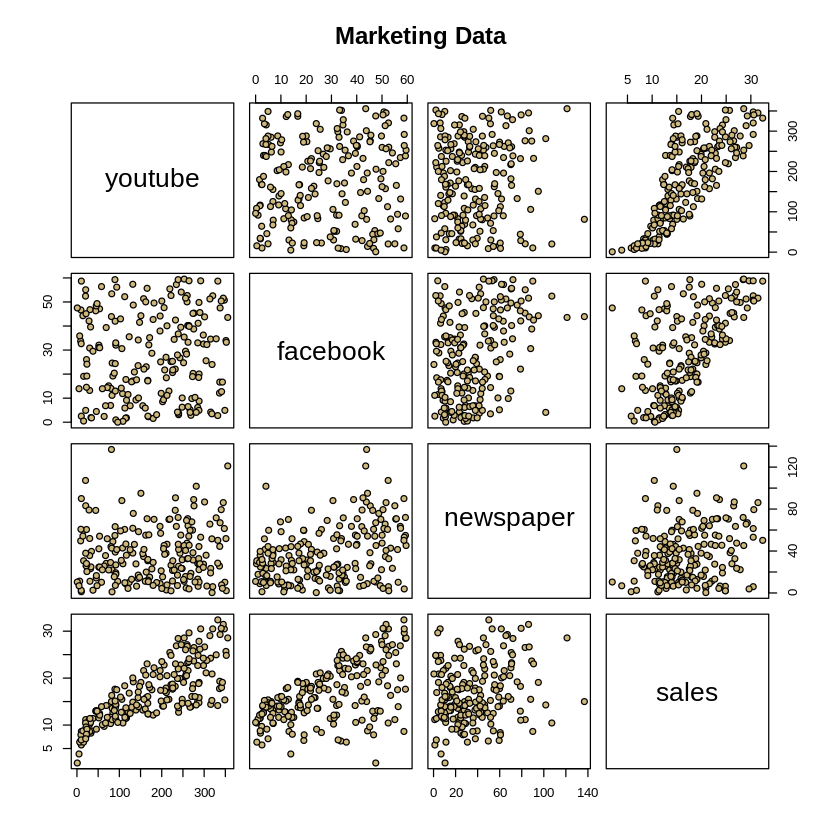

In [6]:
# Load in the data
marketing = read.csv("marketing.txt", sep="")
summary(marketing)
pairs(marketing, main = "Marketing Data", pch = 21, bg = c("#CFB87C"))

In [7]:
set.seed(1771) #set the random number generator seed.
n = floor(0.8 * nrow(marketing)) #find the number corresponding to 80% of the data
index = sample(seq_len(nrow(marketing)), size = n) #randomly sample indicies to be included in the training set

train_marketing = marketing[index, ] #set the training set to be the randomly sampled rows of the dataframe
test_marketing = marketing[-index, ] #set the testing set to be the remaining rows
dim(test_marketing) #check the dimensions
dim(train_marketing) #check the dimensions

[1] 40  4

[1] 160   4

**1.(a) Working with nonlinearity: Kernel regression**

Note that the relationship between `sales` and `youtube` is nonlinear. This was a problem for us back in the first course in this specialization, when we modeled the data as if it were linear. For now, let's just focus on the relationship between `sales` and `youtube`, omitting the other variables (future lessons on generalized additive models will allow us to bring back other predictors).

Using the `train_marketing` set, plot `sales` (response) against `youtube` (predictor), and then fit and overlay a kernel regression. Experiment with the bandwidth parameter until the smooth looks appropriate, or comment why no bandwidth is ideal. Justify your answer.

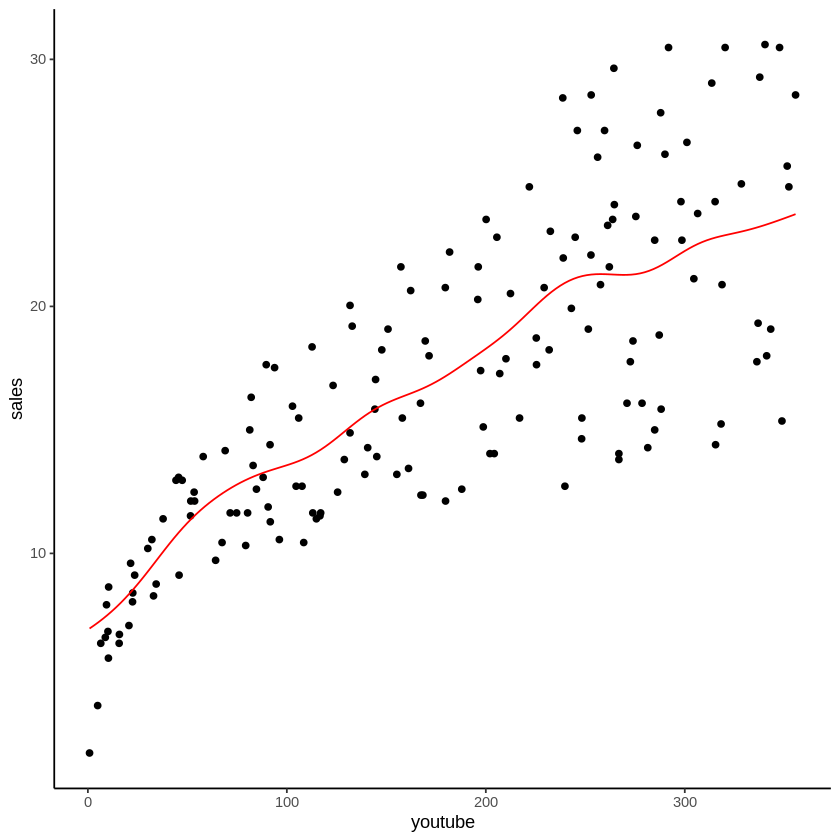

In [24]:
# xvar yvar kernel bandwith
z = ksmooth(train_marketing$youtube, train_marketing$sales, "normal", 50)

train_marketing %>% 
    ggplot(aes(x = youtube, y = sales)) +
    geom_point() +
    geom_line(aes(x = z$x, y = z$y), col = "red") +
    theme_classic()

Bandwidths starting with a value of one were tried until it was deemed that the final value tried was roughly appropriate. The author also experimented with the "box" kernel, but found that a "normal" bandwidth produced a smoother line. However, all the fits were still too wiggly at higher values of the x-variable.

**1.(b) Working with nonlinearity: Smoothing spline regression**

Again, using the `train_marketing` set, plot `sales` (response) against `youtube` (predictor). This time, fit and overlay a smoothing spline regression model. Experiment with the smoothing parameter until the smooth looks appropriate. Explain why it's appropriate and justify your answer.

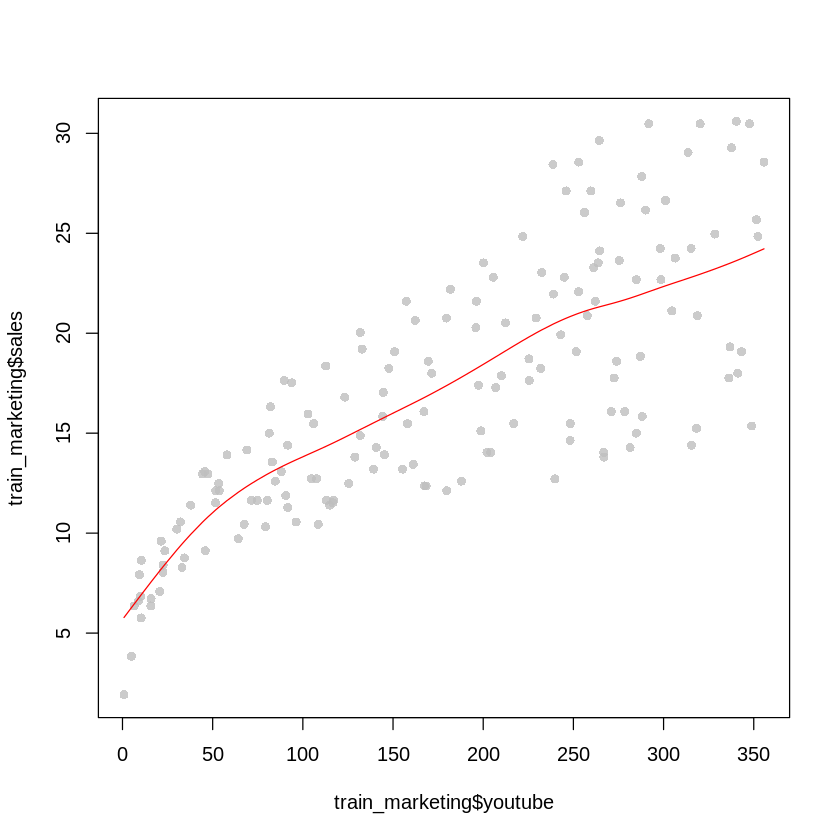

In [5]:
# trial-and-error result
plot(train_marketing$sales ~ train_marketing$youtube, pch = 16, col = alpha("grey", 0.8))
lines(smooth.spline(x = train_marketing$youtube, y = train_marketing$sales, spar = 0.9), col = "red")

In [6]:
# result using cross-validation

spar_seq = seq(from=0.05,to=2, by=0.05) # grid of spar values
CV_err_spar = rep(NA,length(spar_seq)) 

for(j in 1:length(spar_seq)){
    spar_using = spar_seq[j] 
    CV_err = rep(NA, n) #recall that n is the sample size, as defined above
    for(i in 1:n){
        x_test = train_marketing$youtube[i] #leave one x value out for CV
        y_test = train_marketing$sales[i] #leave one y value out for CV

        x_tr = train_marketing$youtube[-i] #make the remaining x values the x values for the training set
        y_tr = train_marketing$sales[-i] #make the remaining y values the y values for the training set
     
    y_test_predict = predict(smooth.spline(x = x_tr,y = y_tr, spar = spar_using), x_test) #predicted value in test set
    CV_err[i] = (y_test - y_test_predict$y)^2 # squared error
    }
    
CV_err_spar[j] = mean(CV_err) #CV: mean of the squared errors
    
}

s = spar_seq[which.min(CV_err_spar)] #the "best" spar value, as measured by leave-one-out CV

cat("The cross validation procedure chooses spar = ", s, ".")

The cross validation procedure chooses spar =  1.1 .

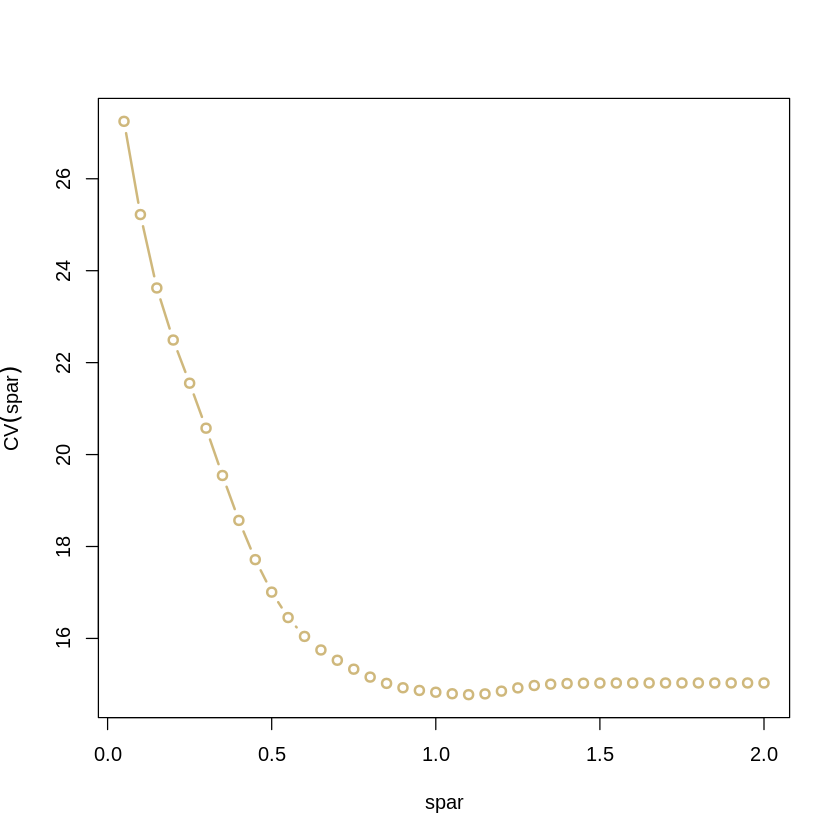

In [7]:
plot(x=spar_seq, y=CV_err_spar, type="b", lwd=2, col="#CFB87C", 
     xlab="spar", ylab= expression(CV(spar)))

The spar parameter was again chosen by trial and error. A cross-check against a more systematic search using cross-validation (adapting the script in the Smoothing Splines lab), indicated that the guess was very accurate. It was also better than the kernel regression at capturing the slope changes without also reflecting some of the noise.

**1.(c) Working with nonlinearity: Loess**

Again, using the `train_marketing` set, plot `sales` (response) against `youtube` (predictor). This time, fit and overlay a loess regression model. You can use the `loess()` function in a similar way as the `lm()` function. Experiment with the smoothing parameter (`span` in the `geom_smooth()` function) until the smooth looks appropriate. Explain why it's appropriate and justify your answer.

`geom_smooth()` using formula 'y ~ x'



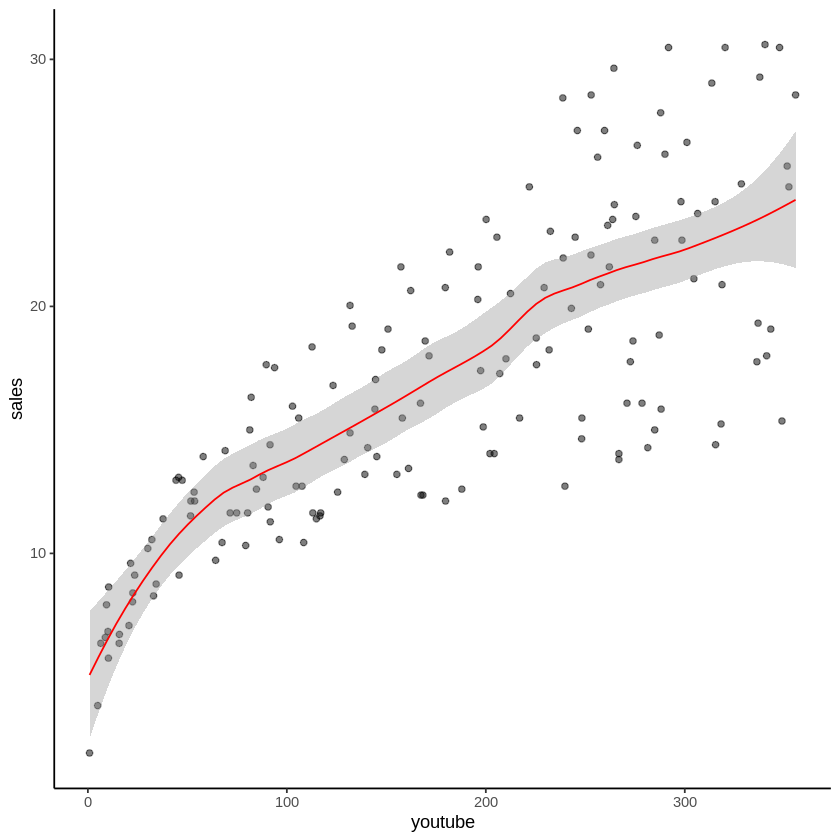

In [8]:
train_marketing %>%
    ggplot(aes(youtube, sales)) + 
        geom_point(color = "black", alpha = 0.5) + 
        geom_smooth(method = "loess", colour = "red", lwd = 0.5, span = 0.5) +
        theme_classic()

As with all the previous approaches, trial-and-error was used until a value of span that looked appropriate was found. Both the loess and smoothing spline produced the best results by purely eye-balling the results.

**1.(d) A prediction metric**

Compare the models using the mean squared prediction error (MSPE) on the `test_marketing` dataset. That is, calculate the MSPE for your kernel regression, smoothing spline regression, and loess model, and identify which model is best in terms of this metric.

Remember, the MSPE is given by 

\begin{align*}
MSPE = \frac{1}{k}\sum^k_{i=1}\left(y^\star_i - \widehat{y}^\star_i \right)^2 
\end{align*}

where $y^\star_i$ are the observed response values in the test set and $\widehat{y}^\star_i$ are the predicted values for the test set (using the model fit on the training set).

In [34]:
# predict the kernel regression model output
kernel_preds <- ksmooth(train_marketing$youtube, train_marketing$sales, "normal", 50, x.points = test_marketing$youtube)$y
kernel_mspe <- mean((test_marketing$sales - kernel_preds) ** 2)
kernel_mspe

# fit the spline model
spline_mod <- smooth.spline(x = train_marketing$youtube, y = train_marketing$sales, spar = 0.9)
# predict the spline model output
spline_preds <- predict(spline_mod, x = test_marketing$youtube)$y
spline_mspe <- mean((test_marketing$sales - spline_preds) ** 2)
spline_mspe

# fit the loess model
loess_mod <- loess(sales ~ youtube, data = train_marketing, span = 0.5)
loess_preds <- predict(loess_mod, newdata = test_marketing$youtube)
# predict the loess model output
mspe_loess <- mean((test_marketing$sales - loess_preds) ** 2)
mspe_loess

[1] 63.7119

[1] 17.99323

[1] 18.11483

The spline and loess models fit much more accurately than the kernel regression (which was hardly a surprise). However, in this situation the spline model was ever so slightly better than the loess model.

# Problem 2: Simulations!

Simulate data (one predictor and one response) with your own nonlinear relationship. Provide an explanation of how you generated the data. Then answer the questions above (1.(a) - 1.(d)) using your simulated data.

150 pairs of datapoints were simulated by letting $x$ be a random uniform number between - and $\pi/2$, and $y = sin(\pi x_i) = \epsilon_i$ where $\epsilon_i$ is an independent and indentically distributed normal distribution $N(0,0.5^2)$.

In [36]:
#simulated data
set.seed(2023)

n = 150
x = runif(n, 0, pi/2)
y = sin(pi*x) + rnorm(n, 0, 0.5) + 4
df = data.frame(x = x, y = y)
head(df)

# split the data into training and test sets
set.seed(1771)
n = floor(0.8 * nrow(df))
index = sample(seq_len(nrow(df)), size = n)

train_df = df[index, ]
test_df = df[-index, ]
dim(test_df)
dim(train_df)

,x,y
,<dbl>,<dbl>
1,0.73295547,4.703586
2,0.52651672,4.933736
3,0.25575323,4.525606
4,0.62222387,4.935596
5,0.04773922,3.586262
6,0.18988551,4.670962


[1] 30  2

[1] 120   2

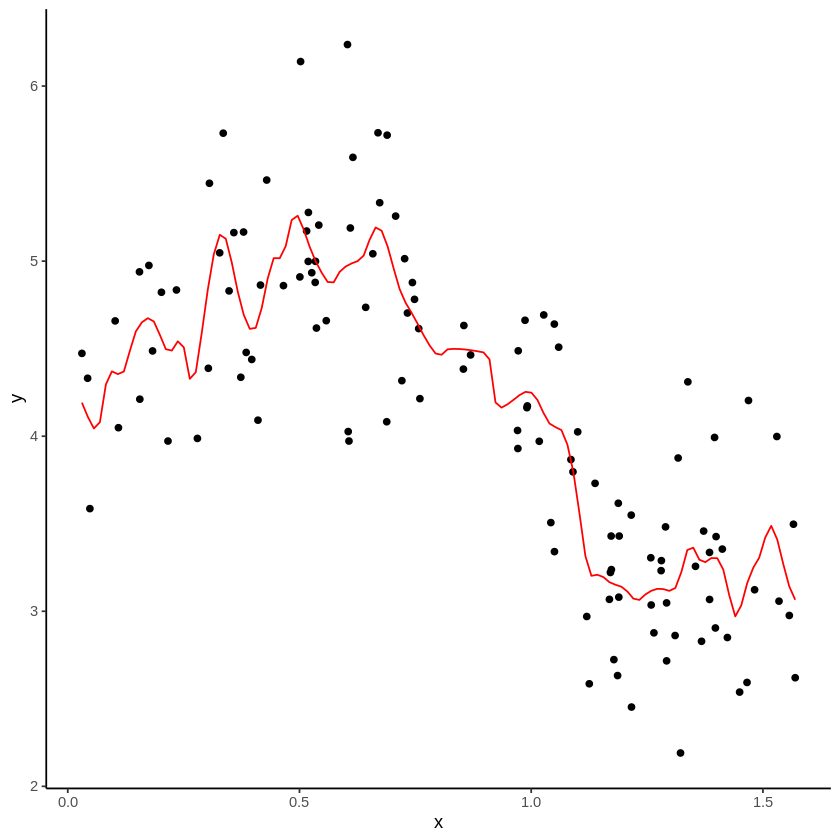

In [52]:
#1.a
z = ksmooth(train_df$x, train_df$y, "normal", 0.05)

train_df %>% 
    ggplot(aes(x = x, y = y)) +
    geom_point() +
    geom_line(aes(x = z$x, y = z$y), col = "red") +
    theme_classic()

Whilst the kernel regression approach was able to identify the main trends in the data, the fit remained too noisy ("wiggly").

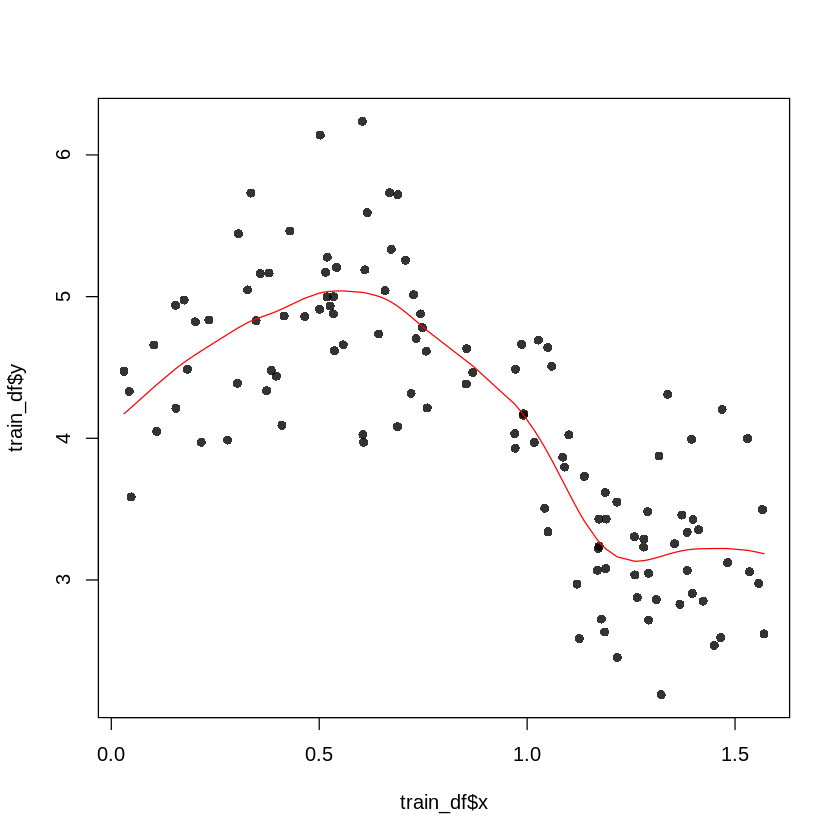

In [53]:
#1.b
plot(train_df$y ~ train_df$x, pch = 16, col = alpha("black", 0.8))
lines(smooth.spline(x = train_df$x, y = train_df$y, spar = 0.8), col = "red")

The smoothing spline approach was a lot better, but it also was influenced by the cluster of 'outlier' points sitting just above the main distribution at the higher values of x.

`geom_smooth()` using formula 'y ~ x'



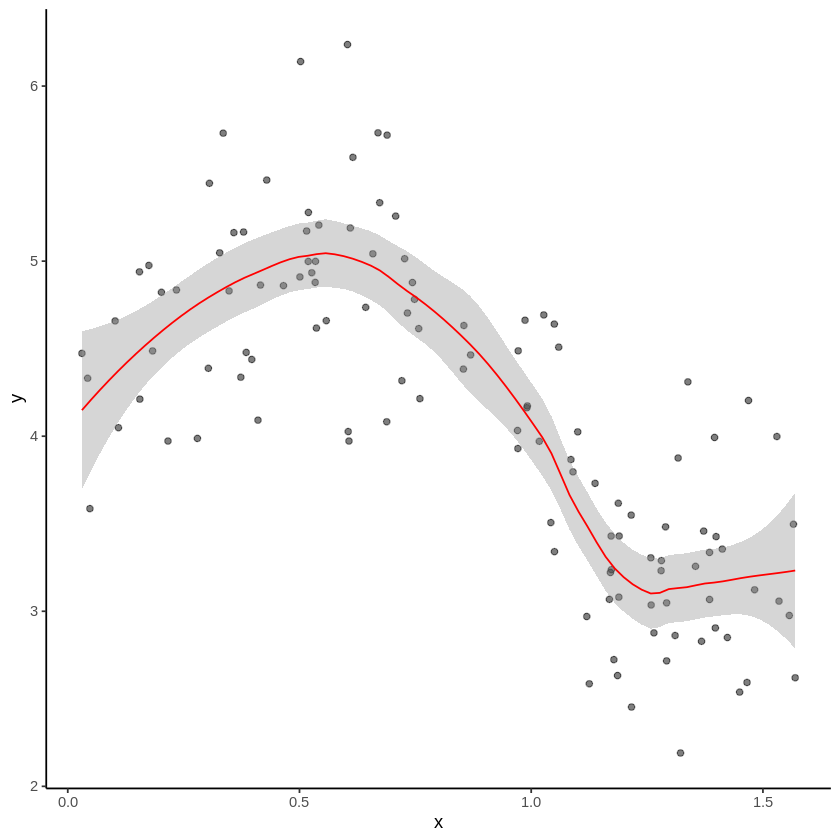

In [54]:
#1.c
train_df %>%
    ggplot(aes(x, y)) + 
        geom_point(color = "black", alpha = 0.5) + 
        geom_smooth(method = "loess", colour = "red", lwd = 0.5, span = 0.5) +
        theme_classic()

The loess model was also pretty good as expected (and possibly the best), except for the upward tick at the end instead of following the main trend downward.

In [58]:
#1.d
# predict the kernel regression model output
kernel_preds <- ksmooth(train_df$x, train_df$y, "normal", 0.05, x.points = test_df$x)$y
kernel_mspe <- mean((test_df$y - kernel_preds) ** 2)
kernel_mspe

# fit the spline model
spline_mod <- smooth.spline(x = train_df$x, y = train_df$y, spar = 0.8)
# predict the spline model output
spline_preds <- predict(spline_mod, x = test_df$x)$y
spline_mspe <- mean((test_df$y - spline_preds) ** 2)
spline_mspe

# fit the loess model
loess_mod <- loess(y ~ x, data = train_df, span = 0.5)
loess_preds <- predict(loess_mod, newdata = test_df$x)
# predict the loess model output
mspe_loess <- mean((test_df$y - loess_preds) ** 2)
mspe_loess

[1] 0.9771348

[1] 0.2311252

[1] 0.2312883

Consistent with the previous observations and the analysis on the 'real' data, the loess and smoothing spline models clearly outperformed the kernel regression. The smoothing spline model marginally outperformed the loess model.